# Import dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Connect to database

In [3]:
# Connect to sqlite database using SQLAlchemy ORM
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Temperature Analysis II

In [8]:
def calc_temps(start_date, end_date):
    """Calculate minimum (TMIN), average (TAVE), and maximum (TMAX) 
        temperatures for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # TODO: write a function that meets the requirements specified above
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return results

calc_temps('2017-08-01', '2017-08-23')

[(70.0, 78.82417582417582, 85.0)]

In [9]:
# Using your function, calculate the min, avg, and max for the matching dates
# from the previous year
trip_results = calc_temps('2016-08-01', '2016-08-23')
trip_results

[(71.0, 78.15436241610739, 83.0)]

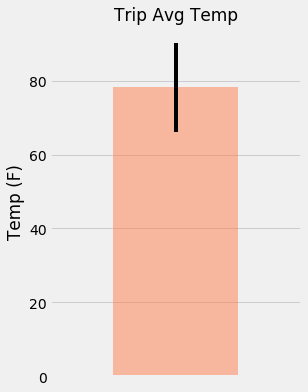

In [18]:
# Plot results as a bar chart per instructions in README
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp = trip_df['Avg Temp']
# Creating the bar plot
# Use "Trip Avg Temp" as the title.
# Use the average temperature as the bar height (y value).
# Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(4,6), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=17)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(zorder=0)
# plt.savefig("Images/TripTempAvg.png")
plt.show()

## Daily Rainfall Average

In [ ]:
# Query rainfall per weather station for previous year, sorted by precipitation
# Include station, name, latitude, longitude, and elevation


## Daily Temperature Normals

In [ ]:
def daily_normals(date):
    """Calculate Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals: tmin, tavg, and tmax
    
    """
    
    # TODO: write a function that meets the requirements specified above


In [ ]:
# Calculate the daily normals for each day of your trip (inclusive)

start_date = '2017-08-01'
end_date = '2017-08-07'


In [ ]:
# Load results into a dataframe per README instructions

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session